In [1]:
import os
import cv2
import torch
from pathlib import Path
from io import BytesIO
from fastai.vision.all import *

c:\Users\Geetansh\Desktop\BioID\Mlvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Model

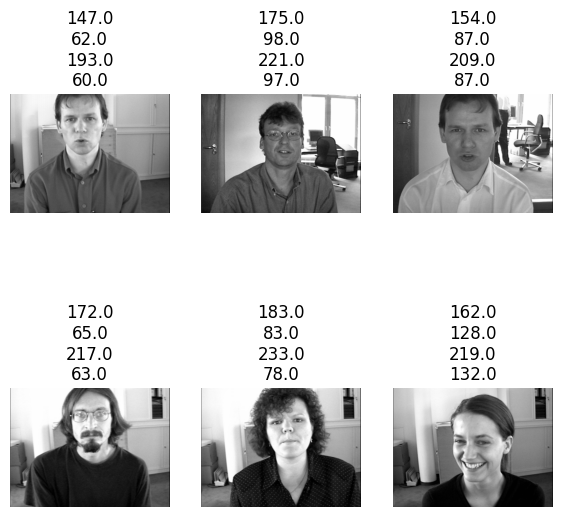

In [2]:
# Path to your dataset
trn_path = Path(r"./BioID-FaceDatabase-V1.2/")  # Replace with your BioID dataset folder path

# Function to parse eye position labels from `.eye` files
def parse_eye_positions(eye_file):
    with open(eye_file, 'r') as f:
        lines = f.readlines()
        left_eye_x, left_eye_y, right_eye_x, right_eye_y = map(float, lines[1].split())
        return left_eye_x, left_eye_y, right_eye_x, right_eye_y

# Functions to extract each target, swapped to match image's perspective
def get_left_eye_x(image_path):
    eye_file = image_path.with_suffix('.eye')
    return parse_eye_positions(eye_file)[2]  # Right eye X (person's left eye)

def get_left_eye_y(image_path):
    eye_file = image_path.with_suffix('.eye')
    return parse_eye_positions(eye_file)[3]  # Right eye Y (person's left eye)

def get_right_eye_x(image_path):
    eye_file = image_path.with_suffix('.eye')
    return parse_eye_positions(eye_file)[0]  # Left eye X (person's right eye)

def get_right_eye_y(image_path):
    eye_file = image_path.with_suffix('.eye')
    return parse_eye_positions(eye_file)[1]  # Left eye Y (person's right eye)

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock),
    n_inp=1,
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=[get_left_eye_x, get_left_eye_y, get_right_eye_x, get_right_eye_y],
)

#Create the DataLoaders
dls = dblock.dataloaders(trn_path, bs=20)  # Adjust batch size as needed

# Visualize a batch
dls.show_batch(max_n=6, figsize=(7, 7))

In [3]:
# Loss Functions
def MSELossFlat(input, target):
    return ((input - target)**2).mean()

def net_Loss(input_from_model, leftEyeX, leftEyeY, rightEyeX, rightEyeY):
    leftEyeX /= 384  # Normalize width
    rightEyeX /= 384
    leftEyeY /= 286  # Normalize height
    rightEyeY /= 286
    return (
        MSELossFlat(input_from_model[:, 0], leftEyeX) +
        MSELossFlat(input_from_model[:, 1], leftEyeY) +
        MSELossFlat(input_from_model[:, 2], rightEyeX) +
        MSELossFlat(input_from_model[:, 3], rightEyeY)
    )

# architecture = 'convnext_small_in22k' #Best Validation MSE : 5509446.000000 (10 epochs) (lr = 0.1)
architecture = 'convnext_tiny' #Best Validation MSE : 327073 (10 epochs) (lr = 0.2)
# architecture = 'regnety_006' #Best Validation MSE :  ( epochs) (lr = )

learn = vision_learner(dls, architecture, loss_func=net_Loss, n_out=4).to_fp16()

In [5]:
learn.load('finalModel4_saved')

### Create Video using model

In [6]:
# Define scaling factors for the BioID format
scaling_factors = torch.tensor([3264, 2448, 3264, 2448])
# scaling_factors = torch.tensor([384, 286, 384, 286])

# Reference positions for left and right eyes
reference_left_eye = (1368, 1063)  # Example reference positions
reference_right_eye = (1784, 1059)

# Path to the directories
image_dir = Path('./PhotoDiaryPrj_Images_Misaligned_New/')
output_dir = Path('./aligned_images_using_model/')
output_dir.mkdir(exist_ok=True)

# Collect image paths
image_paths = list(image_dir.glob('*.jpg'))

aligned_images = []
# temp_pgm_folder_path = r"./temp_pgm_images_during_preprocessing_inference/"

for img_path in image_paths:
    # Step 1: Preprocess the image
    # Read the image
    img = cv2.imread(str(img_path))

    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize to 384x286
    resized_img = cv2.resize(gray_img, (384, 286))

    # Display the resized image 
    # cv2.imshow("Resized Image", resized_img) 
    # cv2.waitKey(0) # Wait for any key press to close the image window 
    # cv2.destroyAllWindows() # Close the image window

    # Save as a temporary PGM file (in-memory or disk-based)
    temp_pgm_path = str(img_path.with_suffix('.pgm'))
    cv2.imwrite(temp_pgm_path, resized_img)

    # Step 2: Predict eye positions using the model
    dl = learn.dls.test_dl([temp_pgm_path])
    predictions = learn.get_preds(dl=dl)
    scaled_predictions = predictions[0][0] * scaling_factors  # Scale predictions to 384x286 dimensions
    left_eye = scaled_predictions[:2].tolist()  # [X, Y] i.e [col, row]
    right_eye = scaled_predictions[2:].tolist()  # [X, Y] i.e [col, row]
    # print("left Eye:", left_eye)
    # print("Right Eye:", right_eye)

    # Step 3: Calculate translation offsets
    left_offset = (reference_left_eye[0] - left_eye[0], reference_left_eye[1] - left_eye[1])
    right_offset = (reference_right_eye[0] - right_eye[0], reference_right_eye[1] - right_eye[1])
    # print(left_offset)
    # print(right_offset)

    # Calculate the average translation
    translation_x = (left_offset[0] + right_offset[0]) / 2
    translation_y = (left_offset[1] + right_offset[1]) / 2
    # print(translation_x)
    # print(translation_y)

    # Step 4: Align the original RGB image
    rows, cols, _ = img.shape
    M = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    aligned_img = cv2.warpAffine(img, M, (cols, rows))

    # Save and collect aligned image
    aligned_img_path = output_dir / img_path.name
    cv2.imwrite(str(aligned_img_path), aligned_img)
    aligned_images.append(aligned_img)

    # Clean up temporary PGM file
    Path(temp_pgm_path).unlink()

print(f"Aligned {len(aligned_images)} images. Aligned images saved to {output_dir}.")


c:\Users\Geetansh\Desktop\BioID\Mlvenv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Geetansh\Desktop\BioID\Mlvenv\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


Aligned 12 images. Aligned images saved to aligned_images_using_model.


In [7]:
# Create a video
video_path = 'aligned_faces_video_using_model.avi'
frame_rate = 2  # Adjust as needed

# Get video dimensions
height, width, _ = aligned_images[0].shape
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(video_path, fourcc, frame_rate, (width, height))

for img in aligned_images:
    video.write(img)

video.release()
print(f"Video saved at {video_path}")

Video saved at aligned_faces_video_using_model.avi


### Create Video without model

In [8]:
# Path to the image directory
image_dir = Path('./PhotoDiaryPrj_Images_Misaligned_New/')

# Collect image paths
image_paths = list(image_dir.glob('*.jpg'))

# Ensure the images are sorted (optional, for sequential naming)
image_paths.sort()

# Read the first image to determine the frame size
first_image = cv2.imread(str(image_paths[0]))
height, width, _ = first_image.shape

# Create a video
video_path = 'aligned_faces_video.avi'
frame_rate = 2  # Adjust as needed

fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(video_path, fourcc, frame_rate, (width, height))

# Add each image to the video
for img_path in image_paths:
    img = cv2.imread(str(img_path))  # Read the image
    video.write(img)  # Add to the video

video.release()
print(f"Video saved at {video_path}")


Video saved at aligned_faces_video.avi
